# Introduction to time series using Tensorflow

### What is Time Series?

Time series is every where, like stock prices, wheather forecast, historical trends and much more. 

What exactly is a time series? It's typically defined as an ordered sequence of values that are usually equally spaced over time.

When we work with single value in time series it is called as Univariate Time Series and similarly when we work with multiple values in time series it is called as Multivariate Time Series. Like stock price of a company, wheather forecast of a place or one historical trend are all Univariate Time Series whereas birth versus death in one place between a time period is Multivariate Time Series. Multivariate Time Series can be a useful in understanding impact of related data just like in birth versus death case. Although they can be treated as separate univariate time series but when shown together they give more insights. Movement of a body can also be plotted as a series of univariates or as a combined multivariate.

Anything that has time factor in it can be analysed using time series.

### What are Applications of Machine Learning in Time Series?

- Prediction of Forecasts of the data
- Imputation (projecting backwards in past)
- Detect Anaomalies (For example, in website logs so that you could see potential denial of service attacks showing up as a spike on the time series)
- Analyze the time series to spot patterns in them that determine what generated the series itself (A classic example of this is to analyze sound waves to spot words in them which can be used as a neural network for speech recognition)

### Common patterns in time series

- Trends (upward, downward, constant) Here time series has specific dimension in which they move
- Seasonality (pattern repeats in predictable intervals)
- Trends + Seasonaity
- Noise (example: white noise)
- Autocorrelation (no trend, no seasonality, it correlates with a delayed copy of itself often called a lag)

Real word = Trends + Seasonality + Noise + Autocorrelation

A machine-learning model is designed to spot patterns, and when we spot patterns we can make predictions. For the most part this can also work with time series except for the noise which is unpredictable. But we should recognize that this assumes that patterns that existed in the past will of course continue on into the future. Of course, real life time series are not always that simple. Their behavior can change drastically over time. 

For example price which was in upward trend goes down drastically (maybe due to financial crisis, big event in company, etc...)

We'll typically call this a **non-stationary time series**. To predict on this we could just train for limited period of time. For example, here where I take just the last 100 steps. You'll probably get a better performance than if you had trained on the entire time series. But that's breaking the mold for typical machine, learning where we always assume that more data is better. But for time series forecasting it really depends on the time series. If it's stationary, meaning its behavior does not change over time, then great. The more data you have the better. But if it's not stationary then the optimal time window that you should use for training will vary. Ideally, we would like to be able to take the whole series into account and generate a prediction for what might happen next. As you can see, this isn't always as simple as you might think given a drastic change like the one we see here.

### Different scenarios for Time Series

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima_model import ARIMA

In [2]:
# For plot time series plots
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#### Trends

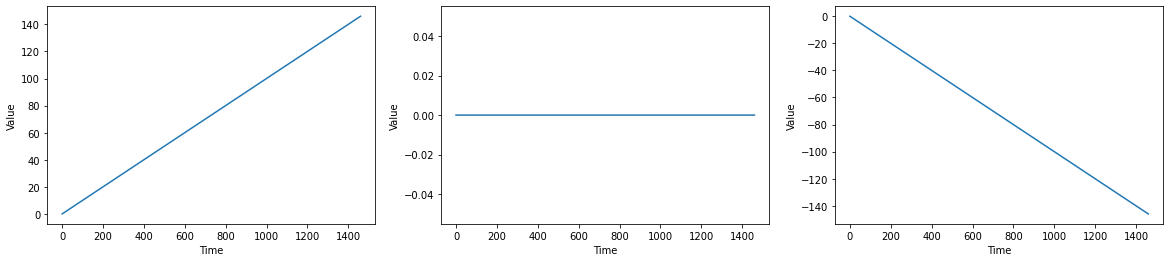

In [3]:
def trend(time, slope=0):
    return slope * time


# 4years (including leap year, therefore + 1 day)
time = np.arange(4 * 365 + 1)

upward_series = trend(time, 0.1)
constant_series = trend(time, 0)
downward_series = trend(time, -0.1)

f, axs = plt.subplots(1, 3, figsize=(20, 4))
axs[0].plot(time, upward_series)
axs[1].plot(time, constant_series)
axs[2].plot(time, downward_series)

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

#### Seasonal

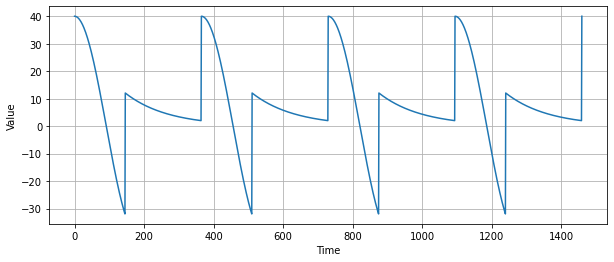

In [4]:
def seasonal_pattern(season_time):
    '''Just an arbitrary pattern, you can change it if you wish'''
    
    # For season_time < 0.4, np.cos(season_time * 2 * np.pi) transformation will be applied
    # and for season_time >= 0.4, 1 / np.exp(3 * season_time) transformation will be applied
    # This will bring a single pattern
    
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time)
    )


def seasonality(time, period, amplitude=1, phase=0):
    '''Repeat the same pattern at each period'''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 4))
plot_series(time, series)
plt.show()

#### Trends + Seasonality

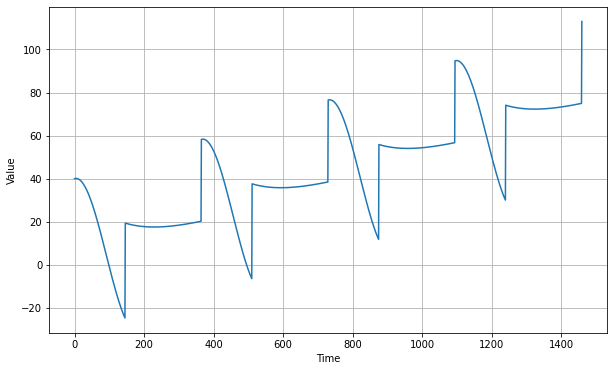

In [5]:
baseline = 0
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

#### Noise

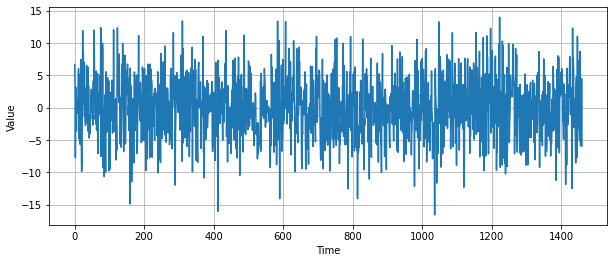

In [6]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


noise_level = 5
noise = white_noise(time, noise_level, seed=10)

plt.figure(figsize=(10, 4))
plot_series(time, noise)
plt.show()

Time Series + Noise

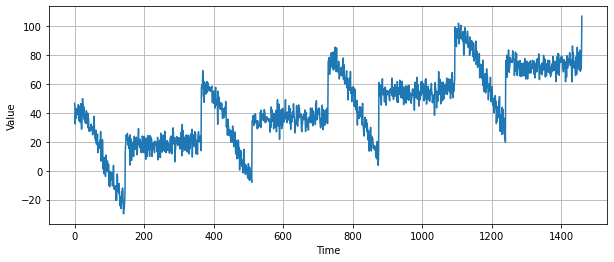

In [7]:
series += noise

plt.figure(figsize=(10, 4))
plot_series(time, series)
plt.show()

#### Simple forecasting using the above data

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [9]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude


def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

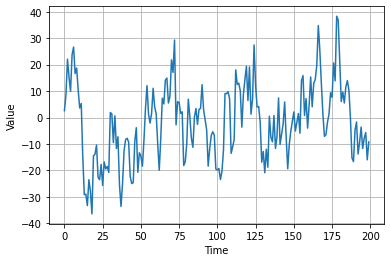

In [10]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

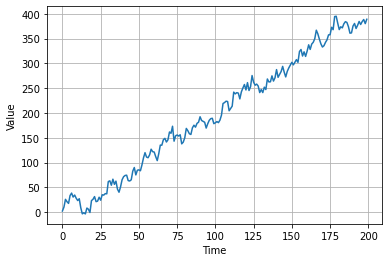

In [11]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

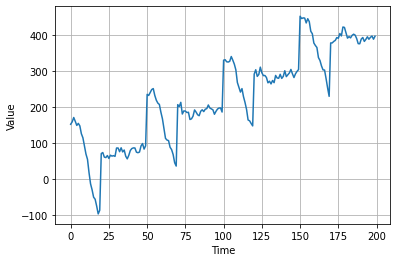

In [12]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

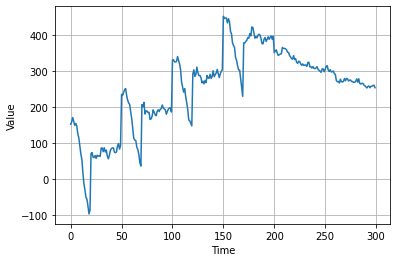

In [13]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
# series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [14]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

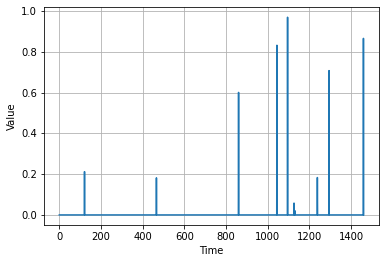

In [15]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [16]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
    return ar

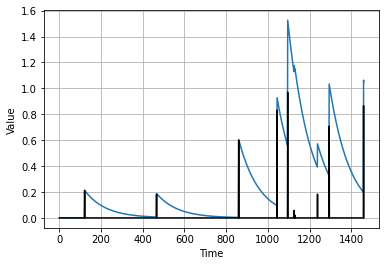

In [17]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, 'k-')
plt.show()

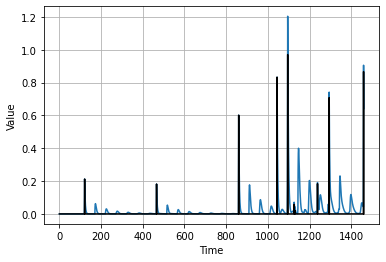

In [18]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, 'k-')
plt.show()

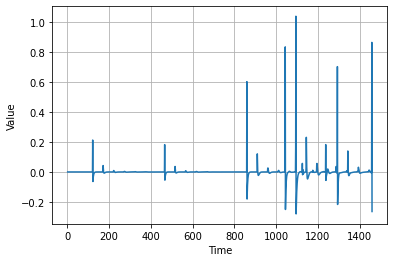

In [19]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

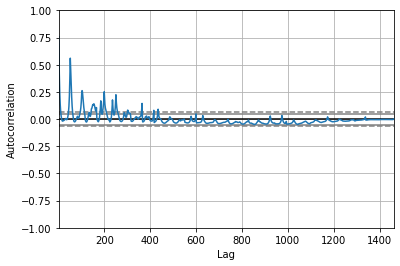

In [20]:
autocorrelation_plot(series)

ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

In [21]:
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Wed, 25 Aug 2021   AIC                          -4432.855
Time:                        14:23:18   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

In [22]:
sunspots_path = '../input/sunspots/Sunspots.csv'
df = pd.read_csv(sunspots_path, parse_dates=['Date'], index_col='Date')
series = df['Monthly Mean Total Sunspot Number'].asfreq('1M')
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

<AxesSubplot:xlabel='Date'>

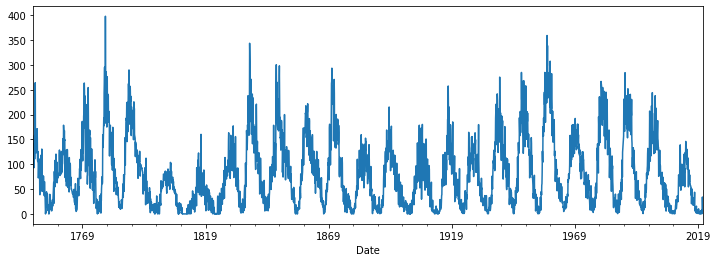

In [23]:
series.plot(figsize=(12, 4))

<AxesSubplot:xlabel='Date'>

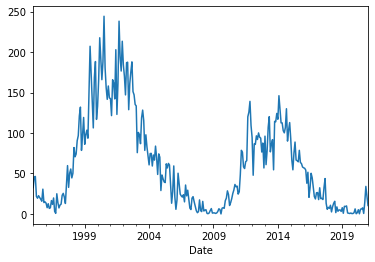

In [24]:
series['1995-01-01':].plot()

(0.0, 100.0, -50.0, 50.0)

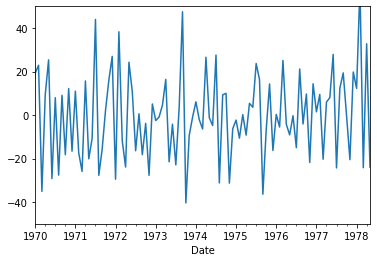

In [25]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

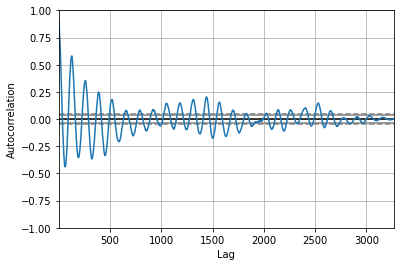

In [26]:
autocorrelation_plot(series)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

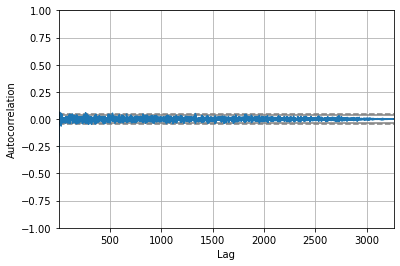

In [27]:
autocorrelation_plot(series.diff(1)[1:])

(0.0, 500.0, -0.1, 0.1)

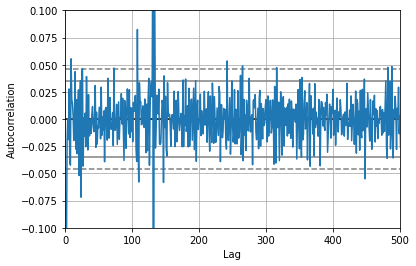

In [28]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

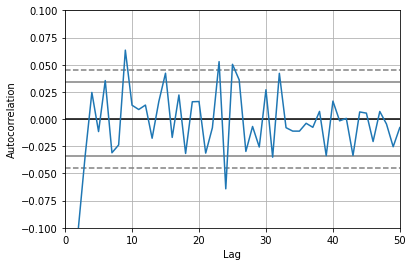

In [29]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [30]:
116.7 - 104.3

12.400000000000006

In [31]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9182467517244699,
 0.8860314675907544,
 0.870085912285519,
 0.8596131174051875,
 0.8451708761214053,
 0.8325965318271725,
 0.8142618537636369,
 0.8009023400742288,
 0.791447210629771,
 0.7715964858658892,
 0.7502927205937702,
 0.7268843381518918,
 0.701322895306846,
 0.6786429949066956,
 0.6533297890337184,
 0.621062076530774,
 0.5915480432972884,
 0.5583968547228385,
 0.5303783891321737,
 0.4997651188716436,
 0.46644947900571454,
 0.4382438732744969,
 0.4113361871304737,
 0.37568579919587414,
 0.35060801667185626,
 0.317229941672387,
 0.2778904817668948,
 0.24342538761999077,
 0.21005712930027434,
 0.18094707014450567,
 0.14732334769300306,
 0.11953585035853213,
 0.08483999797636106,
 0.05141698357367439,
 0.019766987165276965,
 -0.010051035153073639,
 -0.03924592482682632,
 -0.06721901678897514,
 -0.0964207671745006,
 -0.12002061018481744,
 -0.14620120611599668,
 -0.17214652044799061,
 -0.19836293254853696,
 -0.21895351970191299,
 -0.2406374309438181,
 -0.2631752528225338,
 -0.282

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

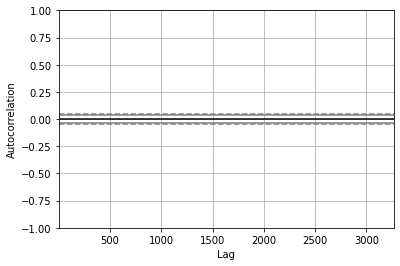

In [32]:
series_diff = series
for lag in range(50):
    series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

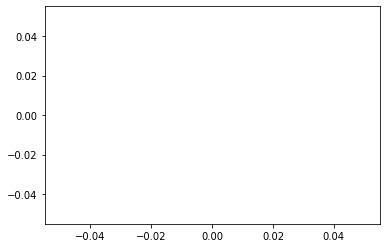

In [33]:
series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()

### Training and Validation sets

**Naive Forecasting** (take the last value and assume that the next value will be the same one, We can do that to get a baseline at the very least, and believe it or not, that baseline can be pretty good).

To measure the performance of our forecasting model, we typically want to split the time series into a training period, a validation period and a test period. This is called **fixed partitioning**. If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons.

You'll train the model on the training period and evaluate it on the validation period. Once you get good results in training and validation data, train the model using the training and validation data then test the model on test data if model is giving good results then you can go ahead and train the model with test data too. Test data is the closest data you have to the current point in time therefore you might want to train using the test data. If your model is not trained using that data, too, then it may not be optimal. Due to this it is very common to use just training and validation data and the test data is in future.

Fixed partitioning like this is very simple and very intuitive, but there's also another way. We start with a short training period, and we gradually increase it, say by one day at a time, or by one week at a time. At each iteration, we train the model on a training period. And we use it to forecast the following day, or the following week, in the validation period. And this is called **roll-forward partitioning**. You could see it as doing fixed partitioning a number of times, and then continually refining the model as such.

### Metrics for evaluating performance

**error = forecast - actual**

#### Metrics

**mse = np.square(errors).mean()**
We square to errors to get rid of negative values, so that negative and positive values don't cancel each other

If we want the mean of our errors' calculation to be of the same scale as the original errors
**rmse = np.sqrt(mse)**

**mae = np.abs(errors).mean()**
Mean Absolute Deviation. In this case, instead of squaring to get rid of negatives, it just uses their absolute value. This does not penalize large errors as much as the mse does. Depending on your task, you may prefer the mae or the mse. For example, if large errors are potentially dangerous and they cost you much more than smaller errors, then you may prefer the mse. But if your gain or your loss is just proportional to the size of the error, then the mae may be better.

**mape = np.abs(errors / x_valid).mean()**
Mean Absolute Percentage Error. This gives an idea of the size of the errors compared to the values.

### Moving average and differencing

A common and very simple forecasting method is to calculate **moving average**. We take average of our time series over a fixed period called an averaging window. Now this nicely eliminates a lot of the noise and it gives us a curve roughly emulating the original series, but it does not anticipate trend or seasonality. Depending on the current time i.e. the period after which you want to forecast for the future, it can actually end up being worse than a naive forecast.

Forecasts = Window Mean

One method to avoid this is to remove the trend and seasonality from the time series with a technique called **differencing**. So instead of studying the time series itself, we study the difference between the value at time t and the value at an earlier period (t - period). Depending on the time of your data, that period might be a year, a day, a month or whatever. We'll get this difference time series which has no trend and no seasonality. We can then use a moving average to forecast this time series which gives us these forecasts. But these are just forecasts for the difference time series, not the original time series. To get the final forecasts for the original time series, we just need to add back the value at difference (t - period)

Forecasts = Moving average of different series + series(t + period)

Our moving average removed a lot of noise but our final forecasts are still pretty noisy. Where does that noise come from? Well, that's coming from the past values that we added back into our forecasts. So we can improve these forecasts by also removing the past noise using a moving average on that. If we do that, we get much smoother forecasts.

Forecasts = Trailing moving average of differenced series + centered moving average of past series (t - period)

#### Trailing versus centered window

Note that when we use the trailing window when computing the moving average of present values, let's say from t minus 30 to t minus one. But when we use a centered window to compute the moving average of past values from one year ago, let's say t minus one year minus five days, to t minus one year plus five days. Then moving averages using centered windows can be more accurate than using trailing windows. But we can't use centered windows to smooth present values since we don't know future values. However, to smooth past values we can afford to use centered windows. 

Simple approaches sometimes can work just fine.

In [34]:
import tensorflow as tf
from tensorflow import keras

In [35]:
# For plot time series plots
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
    
def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    '''Just an arbitrary pattern, you can change it if you wish'''
    
    # For season_time < 0.4, np.cos(season_time * 2 * np.pi) transformation will be applied
    # and for season_time >= 0.4, 1 / np.exp(3 * season_time) transformation will be applied
    # This will bring a single pattern
    
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time)
    )


def seasonality(time, period, amplitude=1, phase=0):
    '''Repeat the same pattern at each period'''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

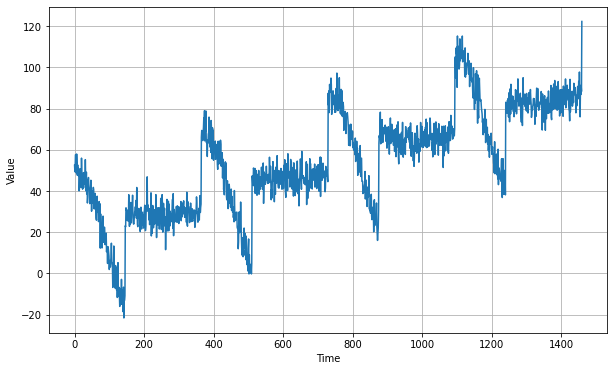

In [36]:
time = np.arange(4 * 365 + 1, dtype='float32')
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Splitting the data

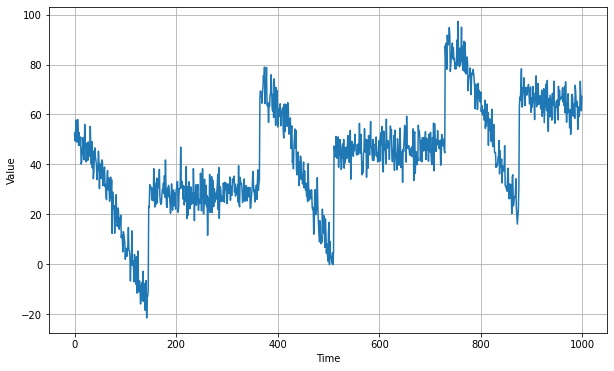

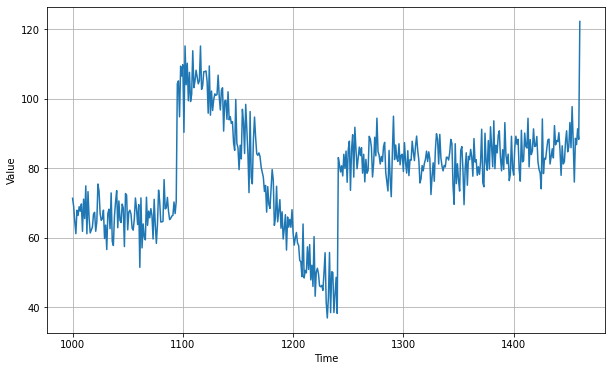

In [37]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

### Naive Forecast

In [38]:
naive_forecast = series[split_time - 1: -1]

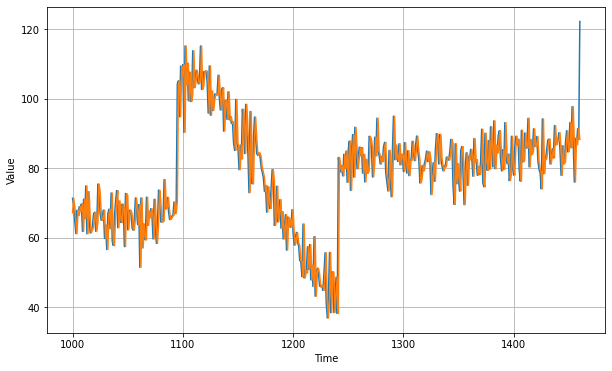

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period

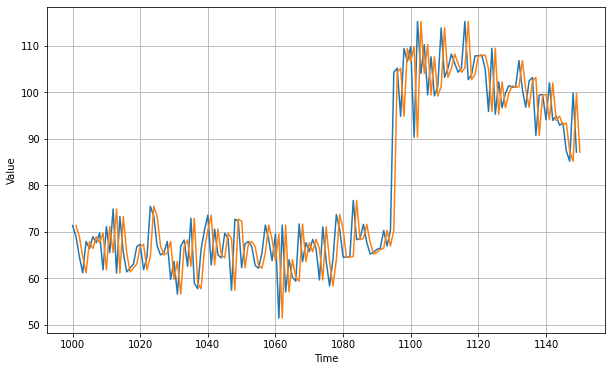

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period

In [41]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.9379086


That's our baseline, now let's try a moving average

In [42]:
def moving_average_forecast(series, window_size):
    '''Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast'''
    
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time: time+window_size].mean())
    return np.array(forecast)

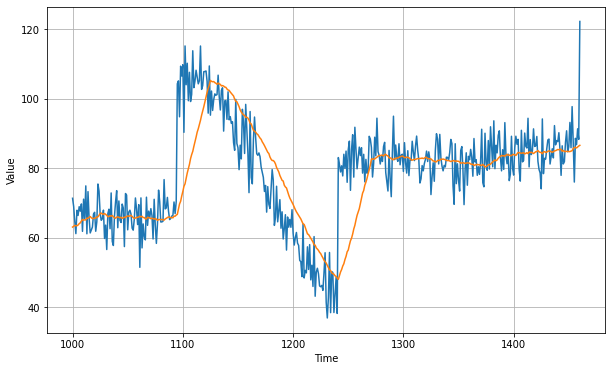

In [43]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [44]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

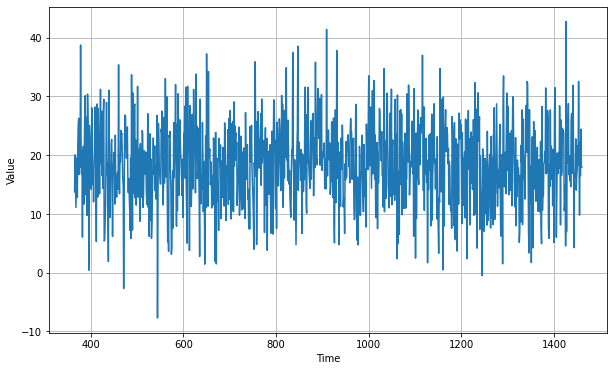

In [45]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average

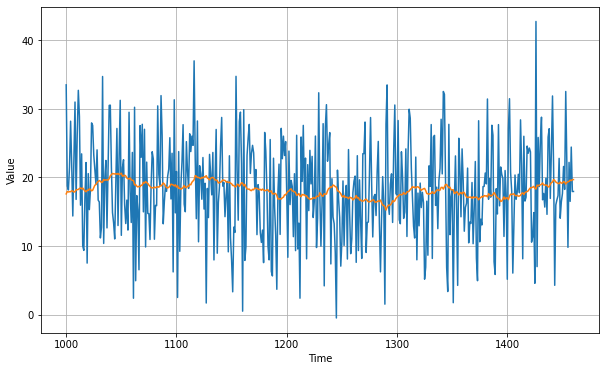

In [46]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365

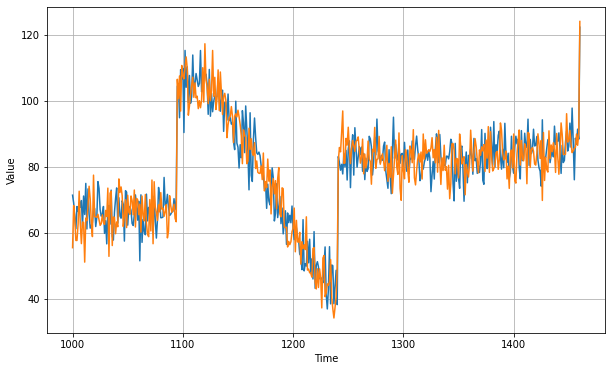

In [47]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [48]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.97366
5.8393106


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise

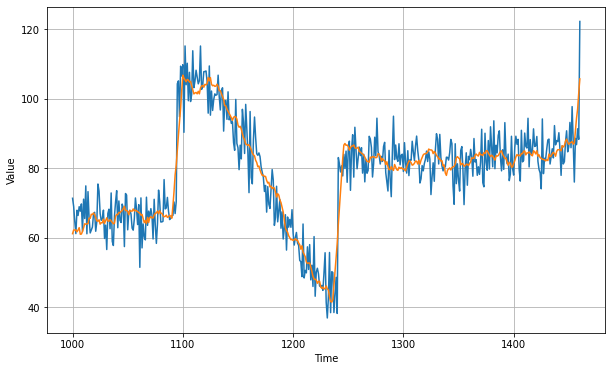

In [49]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [50]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452267
4.569442


## Deep Neural Network for Time Series

### Preparing features and labels

In [51]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [52]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [53]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True) # having the dataset window of same size
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=' ')
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [54]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5)) # creating batch of 5 values
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [55]:
# Splitting the dataset into features and labels
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [56]:
# Shuffling the dataset
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)  # 10 - number of items
for x, y in dataset:
    print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[2 3 4 5] [6]
[1 2 3 4] [5]
[0 1 2 3] [4]
[5 6 7 8] [9]
[4 5 6 7] [8]


In [57]:
# Creating batches
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print(f'x = {x.numpy()}')
    print(f'y = {y.numpy()}')
    print()

x = [[2 3 4 5]
 [1 2 3 4]]
y = [[6]
 [5]]

x = [[5 6 7 8]
 [0 1 2 3]]
y = [[9]
 [4]]

x = [[3 4 5 6]
 [4 5 6 7]]
y = [[7]
 [8]]



#### Sequence bias

Sequence bias is when the order of things can impact the selection of things. For example, if I were to ask you your favorite TV show, and listed "Game of Thrones", "Killing Eve", "Travellers" and "Doctor Who" in that order, you're probably more likely to select 'Game of Thrones' as you are familiar with it, and it's the first thing you see. Even if it is equal to the other TV shows. So, when training data in a dataset, we don't want the sequence to impact the training in a similar way, so it's good to shuffle them up. 

#### Feeding windowed dataset into neural network

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(seires)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

### Single Neural Network

Creating synthetic data

In [59]:
# For plot time series plots
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
    
def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    '''Just an arbitrary pattern, you can change it if you wish'''
    
    # For season_time < 0.4, np.cos(season_time * 2 * np.pi) transformation will be applied
    # and for season_time >= 0.4, 1 / np.exp(3 * season_time) transformation will be applied
    # This will bring a single pattern
    
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time)
    )


def seasonality(time, period, amplitude=1, phase=0):
    '''Repeat the same pattern at each period'''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [60]:
time = np.arange(4 * 365 + 1, dtype='float32')
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [61]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [62]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

layer_0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([layer_0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print(f'Layer weights: {layer_0.get_weights()}')

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>
Layer weights: [array([[-0.11148212],
       [ 0.06371122],
       [ 0.03396788],
       [-0.00954527],
       [ 0.00900268],
       [ 0.08879346],
       [-0.05803084],
       [-0.046221  ],
       [-0.05395359],
       [ 0.13845666],
       [-0.02099377],
       [-0.06684413],
       [-0.03443535],
       [ 0.03050219],
       [ 0.0703375 ],
       [ 0.04749682],
       [ 0.06542028],
       [ 0.08292321],
       [ 0.35207024],
       [ 0.40230152]], dtype=float32), array([0.01781648], dtype=float32)]


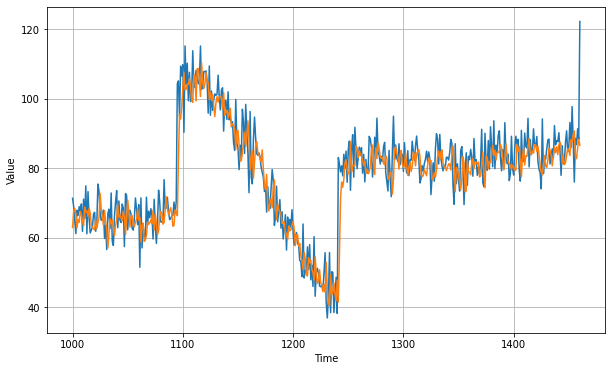

In [63]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [64]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1550045

### Deep Neural Network

In [65]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

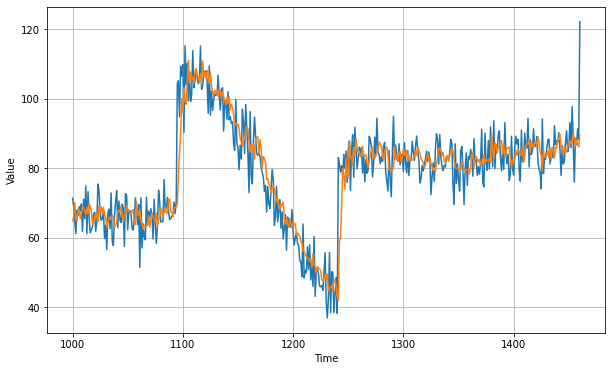

In [66]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time+window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [67]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.852815

In [68]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'), 
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

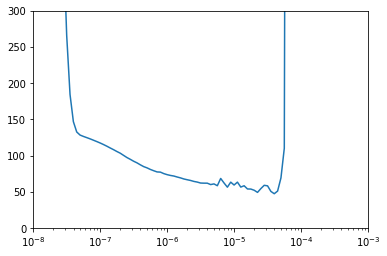

In [69]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

In [70]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

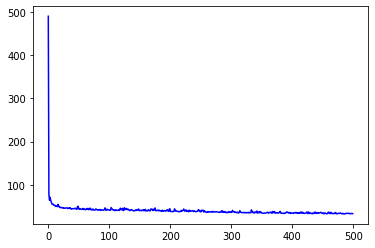

In [71]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[52.582923889160156, 53.04360580444336, 50.817115783691406, 51.73521041870117, 50.25605392456055, 49.971214294433594, 55.164405822753906, 51.46695327758789, 48.895294189453125, 49.31758117675781, 47.30683517456055, 47.740509033203125, 47.9654426574707, 47.276615142822266, 46.42129898071289, 47.64750289916992, 46.42631912231445, 46.3199348449707, 46.13800811767578, 47.02726745605469, 47.14987564086914, 46.71062469482422, 45.39043426513672, 45.99165344238281, 47.302772521972656, 45.52360916137695, 47.24201965332031, 44.686683654785156, 44.04182815551758, 45.03478240966797, 44.964942932128906, 45.154624938964844, 45.36286163330078, 45.14409637451172, 46.20400619506836, 45.9300537109375, 44.14801788330078, 43.739810943603516, 50.44376754760742, 50.23990249633789, 44.8748664855957, 43.51803970336914, 44.66820526123047, 44.96190643310547, 43.545230865478516, 43.63023376464844, 43.95980453491211, 45.94572830200195, 43.20400619506836, 44.857093811035156, 43.36869812011719, 42.67982864379883, 4

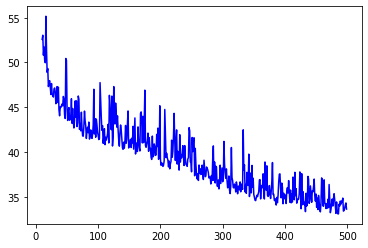

In [72]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

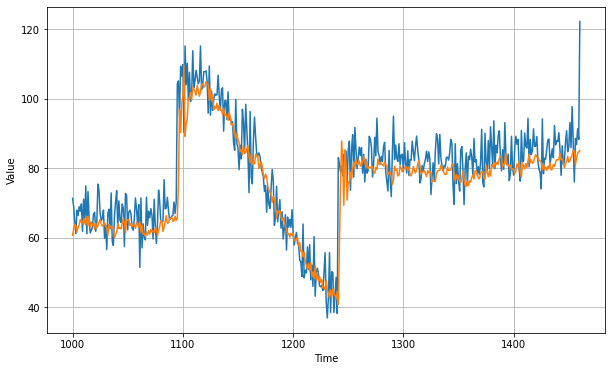

In [73]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [74]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.283491

## RNN

In [75]:
# For plot time series plots
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
    
def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    '''Just an arbitrary pattern, you can change it if you wish'''
    
    # For season_time < 0.4, np.cos(season_time * 2 * np.pi) transformation will be applied
    # and for season_time >= 0.4, 1 / np.exp(3 * season_time) transformation will be applied
    # This will bring a single pattern
    
    return np.where(
        season_time < 0.4,
        np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time)
    )


def seasonality(time, period, amplitude=1, phase=0):
    '''Repeat the same pattern at each period'''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [76]:
time = np.arange(4 * 365 + 1, dtype='float32')
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [77]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [78]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [79]:
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.0001, 0.0, 30.0)

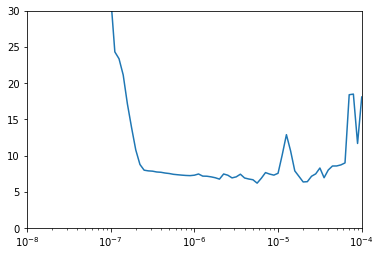

In [80]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Explain last Lambda layer
# if we scale up the outputs by 100, we can help training. The default activation function in the 
# RNN layers is tan H which is the hyperbolic tangent activation. This outputs values between 
# negative one and one. Since the time series values are in that order usually in the 10s like 40s, 
# 50s, 60s, and 70s, then scaling up the outputs to the same ballpark can help us with learning. 

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=400, verbose=0)

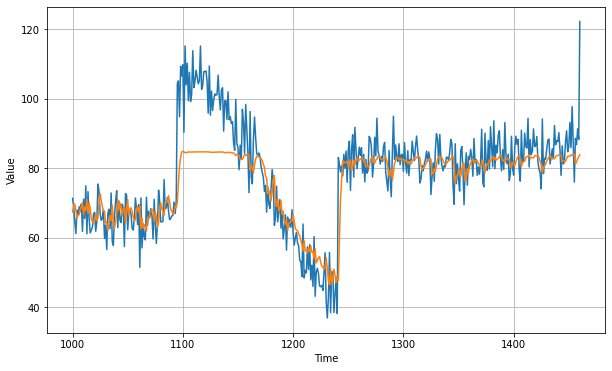

In [82]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [83]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.338194

In [84]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

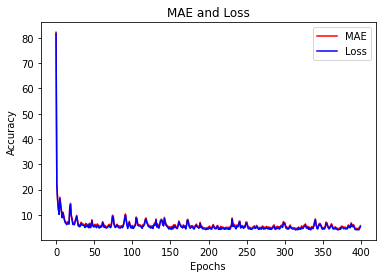

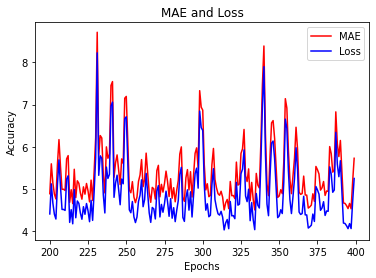

<Figure size 432x288 with 0 Axes>

In [85]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

### LSTMs

Bidirectional LSTMs may not always make sense but if it does like in stock price then using it may give good results.

In [86]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.0001, 0.0, 30.0)

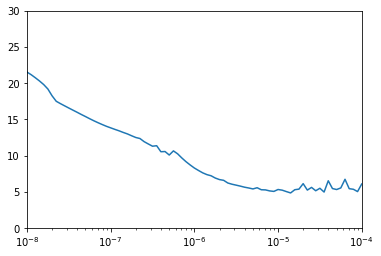

In [87]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [88]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9), metrics=['mae'])
history = model.fit(dataset, epochs=500, verbose=0)

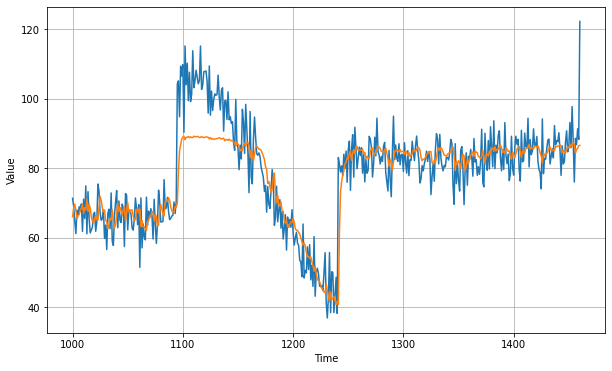

In [89]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [90]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.73778

<Figure size 432x288 with 0 Axes>

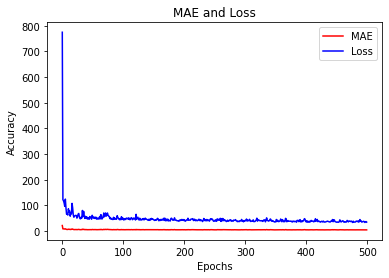

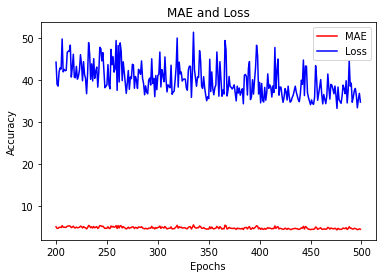

<Figure size 432x288 with 0 Axes>

In [91]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

In [92]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [93]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 7s 12ms/step - loss: 1307.8965
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 176.4447
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 97.3889
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 89.1422
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 79.4352
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 81.9361
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 71.1977
Epoch 8/100
31/31 [==============================] - 0s 12ms/step - loss: 80.9702
Epoch 9/100
31/31 [==============================] - 0s 12ms/step - loss: 72.1485
Epoch 10/100
31/31 [==============================] - 0s 12ms/step - loss: 62.0152
Epoch 11/100
31/31 [==============================] - 0s 12ms/step - loss: 66.4223
Epoch 12/100
31/31 [==============================] - 0s 12ms/step - loss: 56.7716
Epoch 13/1

### Using Convolutional layers

In [94]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [95]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [96]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [97]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.0001, 0.0, 30.0)

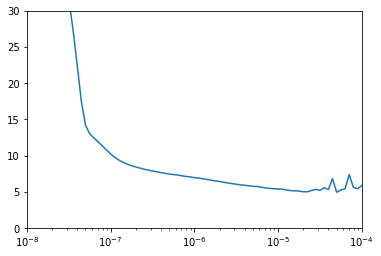

In [98]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [99]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(dataset, epochs=500, verbose=0)

In [100]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

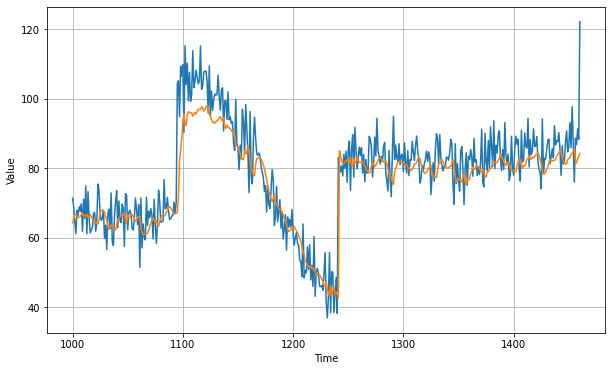

In [101]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [102]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.29639

<Figure size 432x288 with 0 Axes>

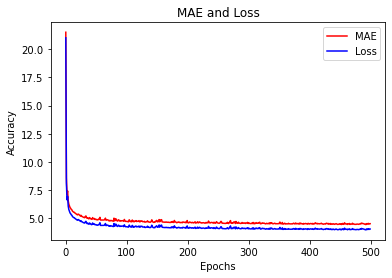

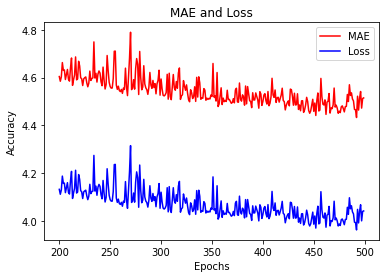

<Figure size 432x288 with 0 Axes>

In [103]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MAE', 'Loss'])

plt.figure()

## Working with Real Data

In [104]:
import csv

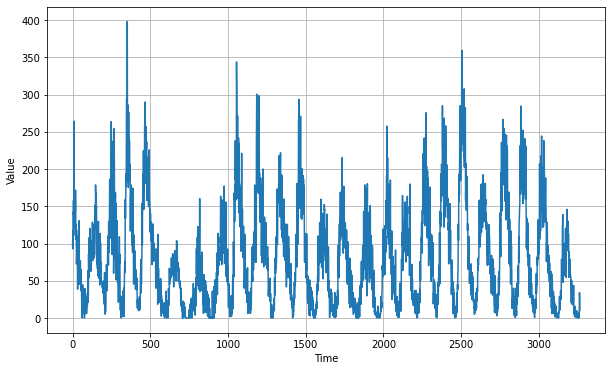

In [105]:
time_step = []
sunspots = []

with open('../input/sunspots/Sunspots.csv') as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    next(reader) # skipping the header
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [106]:
# Splitting the dataset

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [107]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [108]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [109]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], verbose=0)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


(1e-08, 0.0001, 0.0, 60.0)

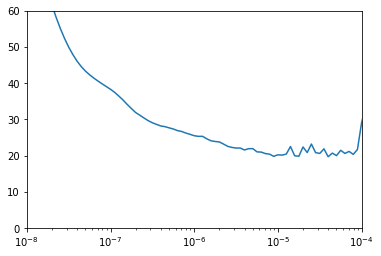

In [110]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 60])

In [111]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=500, verbose=0)

In [112]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

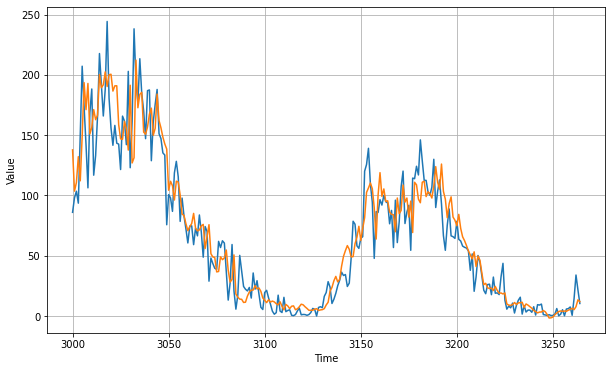

In [113]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [114]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.076302

<Figure size 432x288 with 0 Axes>

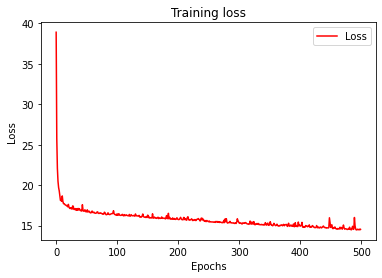

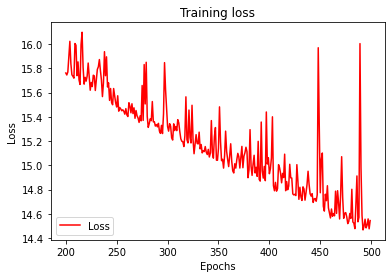

<Figure size 432x288 with 0 Axes>

In [115]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])

plt.figure()

In [116]:
print(rnn_forecast)

[137.79254    103.56462    110.74821    132.16248    112.11522
 149.06726    193.58398    171.16107    192.89093    150.95401
 156.38144    171.19531    162.8409     166.62395    200.23065
 189.3316     191.79254    202.46503    190.35751    200.09808
 200.53235    186.55856    190.91211    190.97308    158.68375
 146.93921    146.54037    161.48634    155.39241    137.64331
 191.3899     126.94962    131.31557    212.24365    172.7278
 183.8147     185.53777    152.54034    150.74332    156.77574
 167.40239    172.40054    149.8658     155.70624    184.07593
 162.10526    156.11131    148.40236    142.74371    138.45036
 104.334175   111.76073    108.044624    96.21427    111.840965
 111.090065   100.340416    84.54388     83.36268     76.49532
  70.74217     74.04468     76.72047     85.11279     72.861626
  70.62178     71.39922     74.74989     75.997795    56.002434
  65.87833     75.75962     51.67801     48.99322     48.57731
  36.58952     36.92012     49.079002    46.72917    

---